In [1]:
from ssri_interactions.transforms.spikes import SpikesHandlerMulti
from ssri_interactions.config import Config, ExperimentInfo
from ssri_interactions.io import load_events, load_derived_generic
from ssri_interactions.responders.foot_shock import SpikeRateResponders
import pandas as pd
import numpy as np
from IPython.display import display
from scipy.stats import zscore, zmap
import warnings
from ssri_interactions.transforms.shock_transforms import ShockUtils
from ssri_interactions.transforms.spikes import SpikesHandler
from ssri_interactions.responders.foot_shock import AlignedResponders
from ssri_interactions.plots import PAL_GREY_BLACK
import seaborn as sns

from sklearn.metrics import mutual_info_score
import ezbootstrap as ez
from sklearn.preprocessing import LabelEncoder
from ssri_interactions.stats import se_mean

%load_ext autoreload
%autoreload 2

In [2]:
def get_response(df, sig_col="sig", diff_col="Diff"):
    return np.where(
        df[sig_col] == True, 
        np.where(df[diff_col] > 0, "activated", "inhibited"), 
        "non responder")

/opt/miniconda3/envs/ssri/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Slow Timescale Effects

### Load data

In [3]:
neuron_types = (
    load_derived_generic("neuron_types.csv")
    .assign(neuron_type=lambda x: pd.Categorical(x.neuron_type, categories=["SR", "SIR", "FF"], ordered=True))
)
sessions = neuron_types.query("experiment_name == 'HAMILTON'").session_name.unique().tolist()
spikes_handler = SpikesHandlerMulti(
    block=["base_shock", "post_base_shock"], 
    bin_width=1, 
    session_names=sessions,
    t_start=-600, 
    t_stop=1200,
)

#### Preprocessing

In [4]:
df_slow = (
    spikes_handler.binned
    .merge(neuron_types)
    .assign(
        block=lambda x: np.select(
            [x["bin"] < 0, x["bin"] < 600, x["bin"] < 1200],
            ["1Pre", "2Shock", "3Post"],
            )
        )
    # .query("block != '3Post'")
    .assign(zcounts=lambda x: x.groupby("neuron_id")["counts"].transform(lambda x: zmap(x, x[:600])))
    .dropna()
)

/var/folders/6b/xc7c961d7wgck5t4ltmpjykh0000gn/T/ipykernel_51212/1552030014.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  .assign(zcounts=lambda x: x.groupby("neuron_id")["counts"].transform(lambda x: zmap(x, x[:600])))


#### Fit Group-level models

In [5]:
mod = SpikeRateResponders(
    df_value_col="zcounts", 
    round_output=2, 
    within_first=True,
    anova_contrast_interaction=True,
    min_diff=0.4,
    )


with warnings.catch_warnings():  # ignore pandas future warning
    warnings.simplefilter("ignore")
    anova, contrasts = mod.get_anova(df_slow, fit_neuron_types=True)

contrasts=(
    contrasts
    .query("A in ('1Pre', '2Shock', '3Post') or block in ('2Shock', '3Post') ")
    .loc[:, ["block", "A", "B", "mean(A)", "mean(B)", "T", "dof", "p-corr", "Sig"]]
)
anova = (
    anova
    .loc[:, ["Source",  "F",  "DF1", "p-unc"]]
)
display(anova)
display(contrasts)

,Source,F,DF1,p-unc
0,neuron_type,4.41,2,0.01
1,block,24.46,2,0.00
2,Interaction,2.15,4,0.07


,block,A,B,mean(A),mean(B),T,dof,p-corr,Sig
0,-,1Pre,2Shock,0.00,0.51,-6.64,463.00,0.00,*
1,-,1Pre,3Post,0.00,0.09,-1.31,463.00,0.19,
2,-,2Shock,3Post,0.51,0.09,4.94,463.00,0.00,*
9,2Shock,SR,SIR,0.44,0.65,-1.32,423.53,0.42,
10,2Shock,SR,FF,0.44,0.02,1.07,39.11,0.46,
11,2Shock,SIR,FF,0.65,0.02,1.58,40.38,0.37,
12,3Post,SR,SIR,0.12,0.18,-0.43,381.04,0.78,
13,3Post,SR,FF,0.12,-0.60,2.89,43.08,0.03,*
14,3Post,SIR,FF,0.18,-0.60,2.96,54.42,0.03,*


### Fit single neuron models

In [6]:

with warnings.catch_warnings():  # ignore pandas future warning
    warnings.simplefilter("ignore")
    anovas, contrast_dict = mod.get_responders(df_slow)

for df in contrast_dict.values():
    df["div_inv"] = df["diff"] * -1
    df["response"] = get_response(df, diff_col="diff_inv")

#### Export

In [7]:
data_dir = Config.data_dir
print(f"Data Dir: {str(data_dir)}")

fn_aov = Config.derived_data_dir / "slow_ts_foot_shock_unit_anovas.csv"
(
    anovas
    .merge(neuron_types[["session_name", "neuron_id", "neuron_type", "group"]])
    .to_csv(fn_aov, index=False)
)
print(f"SU Anovas: {str(fn_aov)}")

print("SU Contrasts:")
for constrast_name, contrast_df in contrast_dict.items():
    fn_contrast = Config.derived_data_dir / f"slow_ts_foot_shock_unit_responders_{constrast_name}.csv"
    (
        contrast_df
        .merge(neuron_types[["session_name", "neuron_id", "neuron_type"]])
        .to_csv(fn_contrast, index=False)
    )
    print(f"\t{constrast_name}: {str(fn_contrast)}")

fn_counts = Config.derived_data_dir / "spike_counts_around_footshock.parquet"
df_slow.to_parquet(fn_counts)
print(f"SU Counts: {str(fn_counts)}")


Data Dir: /Users/ruairiosullivan/repos/SSRI Interactions/data
SU Anovas: /Users/ruairiosullivan/repos/SSRI Interactions/data/derived/slow_ts_foot_shock_unit_anovas.csv
SU Contrasts:
	pre_to_shock: /Users/ruairiosullivan/repos/SSRI Interactions/data/derived/slow_ts_foot_shock_unit_responders_pre_to_shock.csv
	shock_to_post: /Users/ruairiosullivan/repos/SSRI Interactions/data/derived/slow_ts_foot_shock_unit_responders_shock_to_post.csv
	pre_to_post: /Users/ruairiosullivan/repos/SSRI Interactions/data/derived/slow_ts_foot_shock_unit_responders_pre_to_post.csv
SU Counts: /Users/ruairiosullivan/repos/SSRI Interactions/data/derived/spike_counts_around_footshock.parquet


# Time-Locked Effects

#### Utility Funcs

In [8]:
def get_psth_subset(
    t_start, 
    t_stop, 
    block="base_shock", 
    sessions=None, 
    window=(0.05, 0.2)
    ):
    sessions = sessions or ExperimentInfo.foot_shock_sessions_all
    spikes = SpikesHandler(
        block=block,
        bin_width=1,
        session_names=sessions,
        t_start=t_start,
        t_stop=t_stop,
    ).spikes.merge(neuron_types)
    events = (
        load_events(block_name=block)
        .query("event_s >=  @t_start and event_s <= @t_stop")
    )
    transformer = ShockUtils()
    df_binned = transformer.aligned_binned_from_spikes(
        spikes, 
        events, 
        sessions=None,
        bin_width=0.01,
        )
    df_psth = (
        transformer.average_trace_from_aligned_binned(
                df_binned
            )
            .reset_index()
            .melt(id_vars="bin", var_name="neuron_id", value_name="counts")
            .assign(zcounts=lambda x: x.groupby("neuron_id")["counts"].transform(lambda x: zmap(x, x[:45])))
            .merge(neuron_types[["neuron_id", "neuron_type", "session_name"]].drop_duplicates())
            .assign(window=lambda x: np.where(
                (x["bin"] < window[0]) | (x["bin"] > window[1]), "pre", "post"
            ))
    )
    return df_psth

def get_response(df, sig_col="sig", diff_col="Diff"):
    return np.where(
        df[sig_col] == True, 
        np.where(df[diff_col] > 0, "activated", "inhibited"), 
        "non responder")

#### Load Data

In [9]:
neuron_types = (
    load_derived_generic("neuron_types.csv")
    .assign(neuron_type=lambda x: pd.Categorical(x.neuron_type, categories=["SR", "SIR", "FF"], ordered=True))
)
sessions = neuron_types.query("experiment_name == 'HAMILTON'").session_name.unique().tolist()


spikes = SpikesHandler(
    block="base_shock",
    bin_width=1,
    session_names=sessions,
    t_start=0,
    t_stop=600,
).spikes.merge(neuron_types)
events = (
    load_events(block_name="base_shock")
    .query("event_s >= 0 and event_s <= 600")
)


#### Preprocessing (make psth)

In [10]:
transformer = ShockUtils()

df_binned = transformer.aligned_binned_from_spikes(
    spikes, 
    events, 
    sessions=None,
    bin_width=0.01,
    )

window = (0.05, 0.2)
df_psth = (
    transformer.average_trace_from_aligned_binned(
            df_binned
        )
        .reset_index()
        .melt(id_vars="bin", var_name="neuron_id", value_name="counts")
        .assign(zcounts=lambda x: x.groupby("neuron_id")["counts"].transform(lambda x: zmap(x, x[:45])))
        .merge(neuron_types)
        .assign(window=lambda x: np.where(
            (x["bin"] < window[0]) | (x["bin"] > window[1]), "pre", "post"
        ))
)

/var/folders/6b/xc7c961d7wgck5t4ltmpjykh0000gn/T/ipykernel_51212/3865181003.py:17: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  .assign(zcounts=lambda x: x.groupby("neuron_id")["counts"].transform(lambda x: zmap(x, x[:45])))


#### Fit group model & get single neuron responses

In [11]:
mod = AlignedResponders(value_col="zcounts", round_output=2, within_first=True)

with warnings.catch_warnings():  # ignore pandas future warning
    warnings.simplefilter("ignore")
    anova, contrasts = mod.get_anova(df_psth, fit_neuron_types=True)
    responders = mod.get_responders(df_psth, abs_diff_thresh=0.3).assign(fs_fast_response=lambda x: get_response(x))


(
    responders
    .merge(neuron_types)
)

contrasts=(
    contrasts
    .query("window != 'pre'")
)

anova = (
    anova
    .loc[:, ["Source",  "F",  "DF1", "p-unc"]]
)
display(anova)
display(contrasts)
display(responders.sample(3))

,Source,F,DF1,p-unc
0,neuron_type,15.21,2,0.0
1,window,30.69,1,0.0
2,Interaction,14.92,2,0.0


,Contrast,window,A,B,mean(A),std(A),mean(B),std(B),T,dof,p-corr,p-adjust,p,Sig
0,window,-,post,pre,1.99,5.70,0.73,1.31,5.38,455.00,NaN,NaN,0.00,*
1,neuron_type,-,SR,SIR,0.51,1.75,2.23,4.26,-5.43,282.67,0.00,fdr_bh,0.00,*
2,neuron_type,-,SR,FF,0.51,1.75,1.10,2.24,-1.47,41.23,0.15,fdr_bh,0.17,
3,neuron_type,-,SIR,FF,2.23,4.26,1.10,2.24,2.36,81.73,0.03,fdr_bh,0.03,*
4,window * neuron_type,post,SR,SIR,0.49,3.07,3.49,7.30,-5.52,286.28,0.00,fdr_bh,0.00,*
5,window * neuron_type,post,SR,FF,0.49,3.07,1.74,4.07,-1.74,40.80,0.11,fdr_bh,0.11,
6,window * neuron_type,post,SIR,FF,3.49,7.30,1.74,4.07,2.05,76.17,0.07,fdr_bh,0.06,


,neuron_id,n_pre,n_post,Mean_pre,Mean_post,Diff,U,p,sig,fs_fast_response
73,1197,184.0,16.0,0.59,0.79,0.19,1504.5,2.60,False,non responder
81,1209,184.0,16.0,0.82,0.44,-0.38,1680.5,1.07,False,non responder
216,1446,184.0,16.0,-0.02,1.41,1.43,431.0,0.00,True,activated


#### (group-level) numbers in counts

In [12]:
# counts 
with warnings.catch_warnings():  # ignore pandas future warning
    warnings.simplefilter("ignore")
    mod = AlignedResponders(value_col="counts", within_first=False)
    anova, contrasts = mod.get_anova(df_psth, fit_neuron_types=True)
contrasts["mean(A)"] = contrasts["mean(A)"] / 0.01
contrasts["std(A)"] = contrasts["std(A)"] / 0.01
contrasts["mean(B)"] = contrasts["mean(B)"] / 0.01
contrasts["std(B)"] = contrasts["std(B)"] / 0.01
display(contrasts.round(2))

,Contrast,neuron_type,A,B,mean(A),std(A),mean(B),std(B),T,dof,p-corr,p-adjust,p,Sig
0,neuron_type,-,SR,SIR,3.15,3.32,3.43,4.69,-0.73,389.00,0.46,fdr_bh,0.54,
1,neuron_type,-,SR,FF,3.15,3.32,11.64,9.11,-5.46,35.49,0.00,fdr_bh,0.00,*
2,neuron_type,-,SIR,FF,3.43,4.69,11.64,9.11,-5.22,36.97,0.00,fdr_bh,0.00,*
3,window,-,post,pre,4.42,6.78,3.42,3.97,4.99,464.00,NaN,NaN,0.00,*
4,neuron_type * window,SR,post,pre,3.19,4.51,3.10,2.56,0.39,212.00,0.70,fdr_bh,0.70,
5,neuron_type * window,SIR,post,pre,4.27,6.67,2.59,3.20,5.38,216.00,0.00,fdr_bh,0.00,*
6,neuron_type * window,FF,post,pre,12.82,11.69,10.47,7.30,2.00,34.00,0.08,fdr_bh,0.08,


#### export output

In [13]:

data_dir = Config.data_dir
print(f"Data Dir: {data_dir}")

fn_psth = Config.derived_data_dir / "baseshock_counts_psth.parquet"
fn_psth_res = Config.derived_data_dir / "fast_fs_foot_shock_unit_responders.csv"

df_psth.to_parquet(fn_psth)
responders.to_csv(fn_psth_res, index=False)

print(f"PSTH:\n\t{str(fn_psth)}")
print(f"Responders:\n\t{str(fn_psth_res)}")

Data Dir: /Users/ruairiosullivan/repos/SSRI Interactions/data
PSTH:
	/Users/ruairiosullivan/repos/SSRI Interactions/data/derived/baseshock_counts_psth.parquet
Responders:
	/Users/ruairiosullivan/repos/SSRI Interactions/data/derived/fast_fs_foot_shock_unit_responders.csv


### PSTH Second Window

In [14]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df_psth_second_window = get_psth_subset(t_start=0, t_stop=600, sessions=sessions, window=(0.5, 0.8))
    mod = AlignedResponders(value_col="zcounts", within_first=False)
    responders_second_window = mod.get_responders(df_psth_second_window, abs_diff_thresh=0.3)
    responders_second_window["response_second_window"] = get_response(responders_second_window)

data_dir = Config.data_dir
print(f"Data Dir: {data_dir}")

fn_psth_second_window = Config.derived_data_dir / "baseshock_counts_psth_second_window.parquet"
fn_psth_res = Config.derived_data_dir / "fast_fs_foot_shock_unit_responders_second_window.csv"

df_psth_second_window.to_parquet(fn_psth_second_window)
responders_second_window.to_csv(fn_psth_res, index=False)

print(f"PSTH:\n\t{str(fn_psth_second_window)}")
print(f"Responders:\n\t{str(fn_psth_res)}")

Data Dir: /Users/ruairiosullivan/repos/SSRI Interactions/data
PSTH:
	/Users/ruairiosullivan/repos/SSRI Interactions/data/derived/baseshock_counts_psth_second_window.parquet
Responders:
	/Users/ruairiosullivan/repos/SSRI Interactions/data/derived/fast_fs_foot_shock_unit_responders_second_window.csv


In [15]:
from scipy.stats import chi2_contingency


tab_second = (
    responders_second_window
    .merge(neuron_types)
    .query("group in ('SAL', 'CIT') ")
    .pipe(lambda x: pd.crosstab(x.group, x.response_second_window))
)

display(tab_second)
chi2_contingency(tab_second)


response_second_window,activated,inhibited,non responder
group,,,
CIT,111,6,42
SAL,32,3,73


(44.89636224681343,
 1.781881460821293e-10,
 2,
 array([[85.15730337,  5.35955056, 68.48314607],
        [57.84269663,  3.64044944, 46.51685393]]))

In [16]:
tab_first = (
    responders
    .merge(neuron_types)
    .query("group in ('SAL', 'CIT') ")
    .pipe(lambda x: pd.crosstab(x.group, x.fs_fast_response))
)

chi2_contingency(tab_first)


(0.6921388177046611,
 0.7074633811809747,
 2,
 array([[50.02247191, 48.83146067, 60.14606742],
        [33.97752809, 33.16853933, 40.85393258]]))

## First Half, Second Half (PSTH)

#### Make PSTH

In [17]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df_psth_first_half = get_psth_subset(t_start=0, t_stop=300, sessions=sessions)
    df_psth_second_half = get_psth_subset(t_start=300, t_stop=600, sessions=sessions)

#### Fit Models

In [18]:
mod = AlignedResponders(value_col="zcounts", within_first=False)

responders_first_half = mod.get_responders(df_psth_first_half, abs_diff_thresh=0.2)
responders_second_half = mod.get_responders(df_psth_second_half, abs_diff_thresh=0.2)

responders_first_half["response_first_half"] = get_response(responders_first_half)
responders_second_half["response_second_half"] = get_response(responders_second_half)

#### Merge Responses

In [19]:
df_responders = (
    responders_first_half[["neuron_id", "response_first_half"]]
    .merge(
        responders_second_half[["neuron_id", "response_second_half"]],
    )
    .merge(neuron_types[["neuron_id", "neuron_type", "group"]])
)

#### Compare Responders

In [20]:
def compare_responders(df, col1="response_first_half", col2="response_second_half", n_boot=1000):
    le = LabelEncoder()
    x = le.fit_transform(df[col1])
    y = le.transform(df[col2])

    obs = mutual_info_score(x, y)
    obs_reps = ez.bs_pairs(x, y, func=lambda x, y : mutual_info_score(x, y), size=n_boot)
    se = se_mean(obs_reps)
    return pd.Series(dict(observed=obs, se=se))



#### Calculate stability by neuron type

In [21]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    psth_response_stability_by_nt = df_responders.groupby(["neuron_type", "group"]).apply(compare_responders).reset_index()

##### Export

In [22]:
fn_first_half = Config.derived_data_dir / "psth_counts_first_half.parquet"
fn_second_half = Config.derived_data_dir / "psth_counts_second_half.parquet"
df_psth_first_half.to_parquet(Config.derived_data_dir / "psth_second_half.csv", index=True)
df_psth_second_half.to_parquet(Config.derived_data_dir / "psth_first_half.csv", index=True)
print(f"First Half PSTH:\n\t{str(fn_first_half)}")
print(f"Second Half PSTH:\n\t{str(fn_second_half)}")

fn_responders = Config.derived_data_dir / "psth_first_second_half_responders.csv"
df_responders.to_csv(fn_responders, index=False)
print(f"First Second Half Responders:\n\t{str(fn_responders)}")

fn_responders = Config.derived_data_dir / "psth_stability_scores.csv"
psth_response_stability_by_nt.to_csv(fn_responders, index=False)
print(f"Stability Scores:\n\t{str(fn_responders)}")

display(df_psth_first_half.sample(3))
display(df_psth_second_half.sample(3))
display(df_responders.sample(3))
display(psth_response_stability_by_nt.sample(3))

First Half PSTH:
	/Users/ruairiosullivan/repos/SSRI Interactions/data/derived/psth_counts_first_half.parquet
Second Half PSTH:
	/Users/ruairiosullivan/repos/SSRI Interactions/data/derived/psth_counts_second_half.parquet
First Second Half Responders:
	/Users/ruairiosullivan/repos/SSRI Interactions/data/derived/psth_first_second_half_responders.csv
Stability Scores:
	/Users/ruairiosullivan/repos/SSRI Interactions/data/derived/psth_stability_scores.csv


,bin,neuron_id,counts,zcounts,neuron_type,session_name,window
19443,-0.07,1231,0.061224,-0.126210,SR,hamilton_18,pre
45345,0.95,1465,0.013605,-0.177645,SIR,hamilton_08,pre
90322,0.72,2252,0.013605,0.581173,SR,hamilton_30,pre


,bin,neuron_id,counts,zcounts,neuron_type,session_name,window
87490,0.40,2233,0.053691,1.573564,SIR,hamilton_30,pre
26798,1.48,1294,0.006711,0.491089,SIR,hamilton_23,pre
47733,0.83,1485,0.053333,3.872808,SIR,hamilton_08,pre


,neuron_id,response_first_half,response_second_half,neuron_type,group
230,1474,non responder,non responder,SR,CIT
120,1273,non responder,non responder,SIR,CIT
219,1455,non responder,non responder,SIR,CIT


,neuron_type,group,observed,se
7,FF,DIS,0.601142,0.005188
8,FF,SAL,0.627828,0.004283
0,SR,CIT,0.623204,0.002941


# Plots

In [23]:
def stacked_bar_single(df, col, ax):
    df[col].value_counts().to_frame().T.plot(kind="bar", stacked=True, ax=ax, legend=False)
    ax.axis("off")
    return ax

In [24]:
fig_dir = Config.fig_dir / "foot-shock"
fig_dir.mkdir(exist_ok=True, parents=True)

## Slow TS

### All Neuron Heat

In [35]:
def pivot(df, value_col="zcounts", index="neuron_id", columns="bin", aggfunc="mean"):
    return (
        df
        .pivot_table(index=index, columns=columns, values=value_col, aggfunc=aggfunc)
    )

def sort_by_response(df_piv, df_response, df_response_mag_col="diff", **sort_values_kwargs):
    ordered_responders = (
        df_response
        [["neuron_id", "neuron_type", "group", df_response_mag_col]]
        .set_index("neuron_id")
        .reindex(df_piv.index)
        .sort_values(["neuron_type", df_response_mag_col], **sort_values_kwargs)
        .dropna()
    )
    ordered_piv = df_piv.reindex(ordered_responders.index)
    return ordered_piv, ordered_responders



##### Preprocess

In [36]:
# aligned data
slow_counts = df_slow.merge(neuron_types[["neuron_id", "neuron_type", "group"]]).dropna().query("bin <= 600")

# responders
slow_responses = contrast_dict["pre_to_shock"].merge(neuron_types[["neuron_id", "neuron_type", "group"]])

# by group
slow_piv_sal, slow_piv_sal_key = (
    slow_counts
    .query("group == 'SAL'")
    .pipe(pivot)
    .pipe(sort_by_response, df_response=slow_responses.query("group == 'SAL'"))
)
slow_piv_cit, slow_piv_cit_key = (
    slow_counts
    .query("group == 'CIT'")
    .pipe(pivot)
    .pipe(sort_by_response, df_response=slow_responses.query("group == 'CIT'"))
)



##### Plot Heatmaps

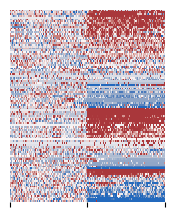

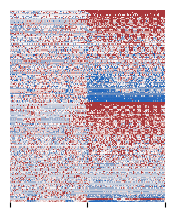

In [37]:
import matplotlib.pyplot as plt

f_sal = plt.figure(figsize=(2, 2.5))
ax = f_sal.subplots()
sns.heatmap(slow_piv_sal, cmap="vlag", center=0, robust=True, vmax=2, vmin=-2, cbar=False, ax=ax)
ax.set_yticks([])
ax.set_xticks([0, 600, 1200])
ax.set_ylabel("")
ax.set_xlabel("")


f_cit = plt.figure(figsize=(2, 2.5))
ax = f_cit.subplots()
sns.heatmap(slow_piv_cit, cmap="vlag", center=0, robust=True, vmax=2,  vmin=-2, cbar=False, ax=ax)
ax.set_yticks([])
ax.set_xticks([0, 600, 1200])
ax.set_ylabel("")
ax.set_xlabel("")

f_sal.savefig(fig_dir / "slow_fs_sal_heatmap.png", bbox_inches="tight", dpi=300)
f_cit.savefig(fig_dir / "slow_fs_cit_heatmap.png", bbox_inches="tight", dpi=300)

##### Plot Key

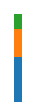

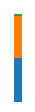

In [28]:
f_sal, ax_sal = plt.subplots(figsize=(0.2, 1.2))
slow_piv_sal.reset_index()[["neuron_id"]].merge(neuron_types).pipe(stacked_bar_single, "neuron_type", ax=ax_sal)


f_cit, ax_cit = plt.subplots(figsize=(0.2, 1.2))
slow_piv_cit.reset_index()[["neuron_id"]].merge(neuron_types).pipe(stacked_bar_single, "neuron_type", ax=ax_cit)

f_sal.savefig(fig_dir / "slow_fs_sal_heatmap_key.png", bbox_inches="tight", dpi=300)
f_cit.savefig(fig_dir / "slow_fs_cit_heatmap_key.png", bbox_inches="tight", dpi=300)

### Single Neuron Response Grid

##### Preprocess

In [14]:
slow_responses = (
    contrast_dict["pre_to_shock"]
    .merge(neuron_types[["neuron_id", "neuron_type", "group"]])
    .assign(diff_inv=lambda x: x["diff"] * -1)
    .query("group in ('SAL', 'CIT')")
)

In [15]:
# slow_responses.query("abs(diff) < 0.3 ")

##### Plot Grid (Seaborn FacetGrid)

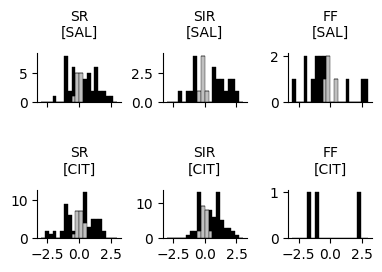

In [16]:
def slow_ts_hist_grid(df, height=0.933, aspect=0.75):
    g = sns.FacetGrid(
        data=df,
        col="neuron_type",
        row="group",
        sharey=False, 
        sharex=True, 
        height=height, 
        aspect=aspect,
        col_order=["SR", "SIR", "FF"],
        gridspec_kws={"wspace": 0.5, "hspace": 1.8},
    )
    g.map_dataframe(
        sns.histplot, 
        x="diff_inv", 
        hue="sig", 
        palette=PAL_GREY_BLACK,
        multiple="stack",
        alpha=1,
        hue_order=[True, False],
        bins=np.arange(-3, 3.1, 0.3),
        )
    g.set_xlabels("")
    g.set_ylabels("")
    return g 


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    g_shock = slow_ts_hist_grid(slow_responses, aspect=1.2, height=1.2)
g_shock.set_titles("{col_name}\n[{row_name}]", pad=12)


In [21]:
from scipy.stats import chi2_contingency
tab_slow = (
    slow_responses
    .merge(neuron_types)
    .query("group in ('SAL', 'CIT') ")
    .pipe(lambda x: pd.crosstab(x.group, x.response))
)

display(tab_slow)
chi2_contingency(tab_slow)

response,activated,inhibited,non responder
group,,,
CIT,78,41,40
SAL,52,33,21


(1.4405183872396976,
 0.48662610922969995,
 2,
 array([[78. , 44.4, 36.6],
        [52. , 29.6, 24.4]]))

/opt/miniconda3/envs/ssri/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/ssri/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


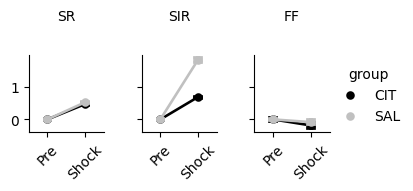

In [17]:
df_slow = (
    df_slow
    .assign(
        block=lambda x: np.select(
            [x["bin"] < 0, x["bin"] < 600, x["bin"] < 1200],
            ["Pre", "Shock", "Post"],
            ))
    .query("group in ('SAL', 'CIT')")
    .query("block != 'Post'")
)
        

g = sns.catplot(
    x="block", 
    y="zcounts", 
    col="neuron_type",
    hue="group",
    sharey=True,
    sharex=True,
    capsize=0.15, 
    height=1, 
    aspect=1.2, 
    color="black",
    kind="point", 
    data=df_slow,
    scale=0.7,
    facet_kws=dict(gridspec_kws=dict(hspace=0.5, wspace=0.5)),
    palette=PAL_GREY_BLACK,
    hue_order=["CIT", "SAL"],
)
g.set_xlabels("")
g.set_ylabels("")
g.set_titles("{col_name}", pad=25)
g.despine()
g.set_xticklabels(["Pre", "Shock"], rotation=45)

## Fast TS

### All Neuron Heat

#### Preprocess

In [30]:

# aligned data
fast_counts = df_psth.merge(neuron_types[["neuron_id", "neuron_type", "group"]]).dropna()

# responders
fast_responses = responders.merge(neuron_types[["neuron_id", "neuron_type", "group"]])



responders_second_window = responders_second_window.merge(neuron_types[["neuron_id", "neuron_type", "group"]])
df_psth_second_window = df_psth_second_window.merge(neuron_types[["neuron_id", "neuron_type", "group"]])

# by group
fast_piv_sal, fast_piv_sal_key = (
    fast_counts
    .query("group == 'SAL'")
    .pipe(pivot)
    .pipe(sort_by_response, df_response=fast_responses.query("group == 'SAL'"), df_response_mag_col="Diff")
)

fast_piv_cit, fast_piv_cit_key = (
    fast_counts
    .query("group == 'CIT'")
    .pipe(pivot)
    .dropna()

    .pipe(sort_by_response, df_response=fast_responses.query("group == 'CIT'"), df_response_mag_col="Diff")
)

#### Plot Heats

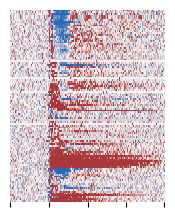

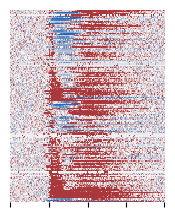

In [34]:
f_sal = plt.figure(figsize=(2, 2.5))
ax = f_sal.subplots()
sns.heatmap(fast_piv_sal, cmap="vlag", center=0, robust=True, vmin=-3, vmax=3, cbar=False, ax=ax)
ax.set_yticks([])
ax.set_xticks([0, 50, 100, 150, 199])
ax.set_ylabel("")
ax.set_xlabel("")


f_cit = plt.figure(figsize=(2, 2.5))
ax = f_cit.subplots()
sns.heatmap(fast_piv_cit, cmap="vlag", center=0, robust=True, vmin=-3, vmax=3, cbar=False, ax=ax)
ax.set_yticks([])
ax.set_xticks([0, 50, 100, 150, 199])
ax.set_ylabel("")
ax.set_xlabel("")

f_sal.savefig(fig_dir / "fast_fs_sal_heatmap.png", bbox_inches="tight", dpi=300)
f_cit.savefig(fig_dir / "fast_fs_cit_heatmap.png", bbox_inches="tight", dpi=300)

##### Plot Neuron Type Key (All Neuron Heat)

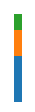

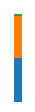

In [32]:
f_sal, ax_sal = plt.subplots(figsize=(0.2, 1.2))
fast_piv_sal.reset_index()[["neuron_id"]].merge(neuron_types).pipe(stacked_bar_single, "neuron_type", ax=ax_sal)


f_cit, ax_cit = plt.subplots(figsize=(0.2, 1.2))
fast_piv_cit.reset_index()[["neuron_id"]].merge(neuron_types).pipe(stacked_bar_single, "neuron_type", ax=ax_cit)

f_sal.savefig(fig_dir / "fast_fs_sal_heatmap_key.png", bbox_inches="tight", dpi=300)
f_cit.savefig(fig_dir / "fast_fs_cit_heatmap_key.png", bbox_inches="tight", dpi=300)

### Single Neuron Response Grid

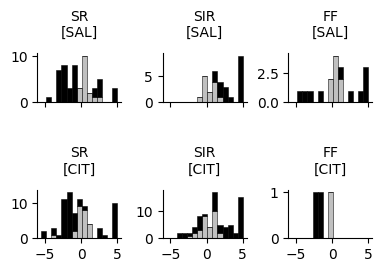

In [79]:
def slow_ts_hist_grid(df, height=0.933, aspect=0.75):
    g = sns.FacetGrid(
        data=df,
        col="neuron_type",
        row="group",
        sharey=False, 
        sharex=True, 
        height=height, 
        aspect=aspect,
        col_order=["SR", "SIR", "FF"],
        gridspec_kws={"wspace": 0.5, "hspace": 1.8},
    )
    g.map_dataframe(
        sns.histplot, 
        x="Diff_round", 
        hue="sig", 
        palette=PAL_GREY_BLACK,
        multiple="stack",
        alpha=1,
        hue_order=[True, False],
        bins=np.arange(-5.5, 5.6, 0.7),
        )
    g.set_xlabels("")
    g.set_ylabels("")
    return g 

fast_responses["Diff_round"] = np.select(
    [fast_responses["Diff"] > 5, fast_responses["Diff"] < -5],
    [5, -5],
    default=fast_responses["Diff"],
    )

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    g_shock = slow_ts_hist_grid(fast_responses.query("group in ('SAL', 'CIT')"), aspect=1.2, height=1.2)
g_shock.set_titles("{col_name}\n[{row_name}]", pad=12)

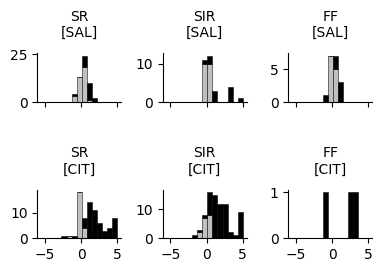

In [80]:
responders_second_window

responders_second_window["Diff_round"] = np.select(
    [responders_second_window["Diff"] > 5, responders_second_window["Diff"] < -5],
    [5, -5],
    default=responders_second_window["Diff"],
    )

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    g_shock = slow_ts_hist_grid(responders_second_window.query("group in ('SAL', 'CIT')"), aspect=1.2, height=1.2)
g_shock.set_titles("{col_name}\n[{row_name}]", pad=12)

### PSTH Response Mag

/opt/miniconda3/envs/ssri/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/ssri/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


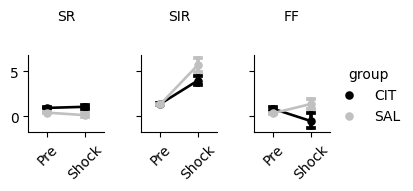

In [74]:
g = sns.catplot(
    x="window", 
    y="zcounts", 
    col="neuron_type",
    hue="group",
    sharey=True,
    sharex=True,
    capsize=0.15, 
    height=1, 
    aspect=1.2, 
    color="black",
    kind="point", 
    data=fast_counts,
    scale=0.7,
    facet_kws=dict(gridspec_kws=dict(hspace=0.5, wspace=0.5)),
    palette=PAL_GREY_BLACK,
    hue_order=["CIT", "SAL"],
)
g.set_xlabels("")
g.set_ylabels("")
g.set_titles("{col_name}", pad=25)
g.despine()
g.set_xticklabels(["Pre", "Shock"], rotation=45)

/opt/miniconda3/envs/ssri/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/ssri/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


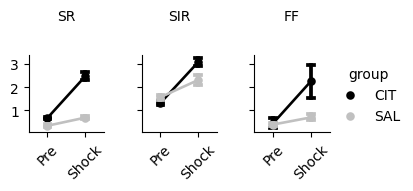

In [86]:
g = sns.catplot(
    x="window", 
    y="zcounts", 
    col="neuron_type",
    hue="group",
    sharey=True,
    sharex=True,
    capsize=0.15, 
    height=1, 
    aspect=1.2, 
    color="black",
    kind="point", 
    data=df_psth_second_window,
    scale=0.7,
    facet_kws=dict(gridspec_kws=dict(hspace=0.5, wspace=0.5)),
    palette=PAL_GREY_BLACK,
    hue_order=["CIT", "SAL"],
)
g.set_xlabels("")
g.set_ylabels("")
g.set_titles("{col_name}", pad=25)
g.despine()
g.set_xticklabels(["Pre", "Shock"], rotation=45)